# Fashion Mnist with feature engineering

## Data Prep

### Lots of Imports

To build predictive models in Python we use a set of libraries that are imported here. In particular **pandas** and **sklearn** are particularly important.

In [3]:
import os
import subprocess
from IPython.display import display, HTML, Image
import io
from operator import itemgetter



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from random import randint
from scipy.misc import toimage

from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn import neural_network

%matplotlib inline
#%qtconsole

### Setup 

Set a data sampling rate for speeding up testing

In [4]:
data_sampling_rate = 0.1

Setup the number of folds for all grid searches

In [5]:
cv_folds = 2

Set up a dictionary to store simple model perofrmance comparions

In [6]:
model_test_accuracy_comparisons = dict()
model_valid_accuracy_comparisons = dict()
model_tuned_params_list = dict()

### Load & Partition Data

Load the dataset and explore it.

In [7]:
dataset = pd.read_csv('fashion-mnist_train.csv')
dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everyhting runs smoothly
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(dataset.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
53309,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48366,3,0,0,0,0,0,0,0,0,0,...,78,0,0,1,0,0,0,0,0,0
23101,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9417,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38653,1,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0


Examine the distribution of the two classes

In [8]:
dataset["label"].value_counts()

1    626
9    621
5    614
4    614
2    600
0    600
8    593
3    592
7    582
6    558
Name: label, dtype: int64

In [9]:
if(dataset.select_dtypes(include=[np.number]).shape[1] > 0):
    display(dataset.select_dtypes(include=[np.number]).describe())
if(dataset.select_dtypes(include=[np.object]).shape[1] > 0):
    display(dataset.select_dtypes(include=[np.object]).describe())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,...,6000.00000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,4.480500,0.002500,0.003833,0.029500,0.131000,0.234500,0.348667,0.730833,1.840167,5.293500,...,33.29600,22.255167,16.250167,17.856667,23.363667,18.388500,9.272833,3.306833,0.878000,0.061667
std,2.885193,0.181198,0.140790,0.514465,3.275865,3.793491,5.000393,7.789619,11.791231,22.354999,...,56.36628,47.582960,41.421438,44.213180,52.205587,45.824312,31.437935,19.328786,9.496217,2.008118
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54.00000,6.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,14.000000,10.000000,34.000000,146.000000,146.000000,230.000000,189.000000,178.000000,228.000000,...,241.00000,249.000000,239.000000,250.000000,254.000000,254.000000,255.000000,248.000000,220.000000,93.000000


In [10]:
# Check for presence of missing values
print("Missing Values")
print(dataset.isnull().sum())

Missing Values
label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
pixel6      0
pixel7      0
pixel8      0
pixel9      0
pixel10     0
pixel11     0
pixel12     0
pixel13     0
pixel14     0
pixel15     0
pixel16     0
pixel17     0
pixel18     0
pixel19     0
pixel20     0
pixel21     0
pixel22     0
pixel23     0
pixel24     0
pixel25     0
pixel26     0
pixel27     0
pixel28     0
pixel29     0
           ..
pixel755    0
pixel756    0
pixel757    0
pixel758    0
pixel759    0
pixel760    0
pixel761    0
pixel762    0
pixel763    0
pixel764    0
pixel765    0
pixel766    0
pixel767    0
pixel768    0
pixel769    0
pixel770    0
pixel771    0
pixel772    0
pixel773    0
pixel774    0
pixel775    0
pixel776    0
pixel777    0
pixel778    0
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64


In [11]:
# Visualise fields
#data_viz(dataset)

In [12]:
# Visualise fields in relation to target
#data_viz_target(dataset, "label")

Isolate the descriptive features we are interested in

In [13]:
X = dataset[dataset.columns[1:]]
Y = np.array(dataset["label"])

Display some of the images

[ 2126 ]  Ankle boot


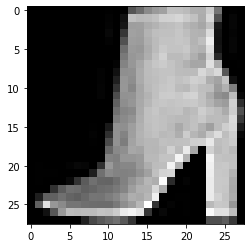

[ 4143 ]  T-shirt/top


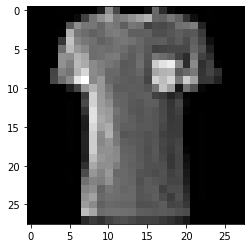

[ 3680 ]  Pullover


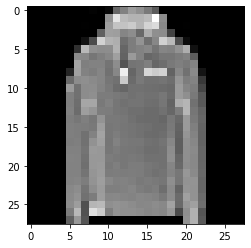

[ 4249 ]  Bag


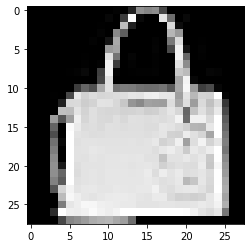

[ 4793 ]  Bag


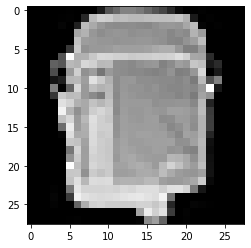

[ 5842 ]  Shirt


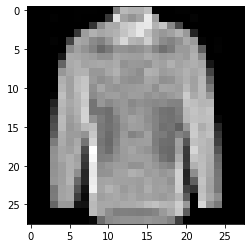

[ 3117 ]  Bag


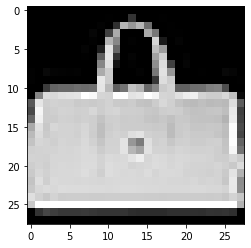

[ 3311 ]  T-shirt/top


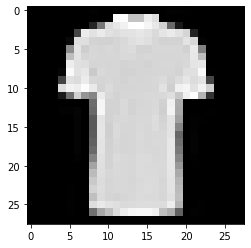

[ 3500 ]  Sneaker


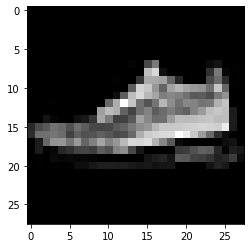

In [14]:
# create a sample of images from the dataset
for i in range(0, 9):
    i_rand = randint(0, X.shape[0])

    print("[", i_rand, "] ", classes[Y[i_rand]])
    two_d = (X.iloc[i_rand].values.reshape(28, 28))
    pyplot.imshow(two_d, cmap='gray')
    pyplot.show()


Normalise the data (important for some models)

In [15]:
X = X/255

Extract some higher level features

In [16]:
engineered_features = pd.DataFrame()

# Calcualte percentage of filled pixels and a top and bottom half only version
percent_filled = X.sum(axis = 1)/(28*28)
percent_filled_top = X.iloc[:, 0:392].sum(axis = 1)/(28*14)
percent_filled_bottom = X.iloc[:, 392:784].sum(axis = 1)/(28*14)
engineered_features['percent_filled'] = percent_filled
engineered_features['percent_filled_top'] = percent_filled_top
engineered_features['percent_filled_bottom'] = percent_filled_bottom

# Calculate the sum of each row
for idx, i in enumerate(range(0, 784, 28)):
    row_sum = X.iloc[:, i:(i + 28)].sum(axis = 1)/28
    engineered_features["row_sum_" + str(idx)] = row_sum

# Calcualte a measure of syymmetry around a horizontal axis
s1 = np.round(np.array(X.iloc[:, 0:392]))
s2 = np.round(np.array(X.iloc[:, 784:391:-1]))
s3 = np.logical_and(s1, s2).astype(int)
symmetry = s3.sum(axis = 1)/(28*28)

engineered_features['symmetry'] = symmetry

display(engineered_features.head(10))

,percent_filled,percent_filled_top,percent_filled_bottom,row_sum_0,row_sum_1,row_sum_2,row_sum_3,row_sum_4,row_sum_5,row_sum_6,...,row_sum_19,row_sum_20,row_sum_21,row_sum_22,row_sum_23,row_sum_24,row_sum_25,row_sum_26,row_sum_27,symmetry
53309,0.345208,0.217747,0.472669,0.000000,0.000000,0.000000,0.000000,0.000000,0.243277,0.373249,...,0.820308,0.843838,0.828711,0.147619,0.000000,0.000000,0.000000,0.000000,0.000000,0.093112
48366,0.290416,0.277621,0.303211,0.099020,0.177451,0.211765,0.238095,0.251681,0.263725,0.286975,...,0.372409,0.350280,0.297759,0.242437,0.237955,0.240616,0.236415,0.261905,0.122689,0.170918
23101,0.354047,0.240686,0.467407,0.000000,0.000000,0.000000,0.000000,0.000000,0.002801,0.152941,...,0.782913,0.755182,0.780392,0.511204,0.058263,0.000000,0.000000,0.000000,0.000000,0.110969
9417,0.361815,0.236275,0.487355,0.000000,0.000000,0.000000,0.000000,0.028291,0.236835,0.387955,...,0.810364,0.813025,0.769188,0.774230,0.452241,0.000000,0.000000,0.000000,0.000000,0.102041
38653,0.163856,0.192947,0.134764,0.113165,0.217787,0.200700,0.226751,0.198739,0.214006,0.235574,...,0.134874,0.153922,0.162465,0.152941,0.147339,0.149720,0.144118,0.143417,0.088095,0.043367
49741,0.441787,0.456923,0.426651,0.000280,0.170588,0.446359,0.474790,0.498880,0.512185,0.510644,...,0.546639,0.548039,0.543697,0.541036,0.538655,0.190056,0.165546,0.131513,0.000140,0.204082
11769,0.372229,0.321128,0.423329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.233473,...,0.746359,0.787955,0.746499,0.019608,0.000000,0.000000,0.000000,0.000000,0.000000,0.150510
3624,0.152731,0.150720,0.154742,0.045378,0.081092,0.087255,0.110084,0.126751,0.128431,0.158683,...,0.189076,0.179412,0.161905,0.146078,0.135294,0.125070,0.124650,0.055462,0.010224,0.082908
8365,0.402006,0.453511,0.350500,0.206022,0.488655,0.505462,0.515406,0.514706,0.561625,0.561905,...,0.351120,0.364846,0.363585,0.375490,0.386555,0.431232,0.335014,0.415826,0.145378,0.225765
53625,0.337925,0.333103,0.342747,0.000000,0.202101,0.358123,0.324650,0.337255,0.337675,0.349160,...,0.610784,0.596499,0.582073,0.366807,0.030952,0.020868,0.020168,0.016667,0.000000,0.099490


In [17]:
X = engineered_features

Split the data into a **training set**, a **vaidation set**, and a **test set**

In [18]:
X_train_plus_valid, X_test, y_train_plus_valid, y_test \
    = train_test_split(X, Y, random_state=0, \
                                    train_size = 0.7)

X_train, X_valid, y_train, y_valid \
    = train_test_split(X_train_plus_valid, \
                                        y_train_plus_valid, \
                                        random_state=0, \
                                        train_size = 0.5/0.7)

## Building Simple Models

### A Very Simple Decision Tree

Train a decision tree

In [19]:
my_tree = tree.DecisionTreeClassifier(criterion="entropy")
my_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### Evaluating Model Performance

Assess the performance of the decision tree on the training set

In [21]:
# Make a set of predictions for the training data
y_pred = my_tree.predict(X_train)

# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_train), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       323
           1       1.00      1.00      1.00       306
           2       1.00      1.00      1.00       277
           3       1.00      1.00      1.00       286
           4       1.00      1.00      1.00       302
           5       1.00      1.00      1.00       298
           6       1.00      1.00      1.00       274
           7       1.00      1.00      1.00       303
           8       1.00      1.00      1.00       322
           9       1.00      1.00      1.00       309

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,323,0,0,0,0,0,0,0,0,0,323
1,0,306,0,0,0,0,0,0,0,0,306
2,0,0,277,0,0,0,0,0,0,0,277
3,0,0,0,286,0,0,0,0,0,0,286
4,0,0,0,0,302,0,0,0,0,0,302
5,0,0,0,0,0,298,0,0,0,0,298
6,0,0,0,0,0,0,274,0,0,0,274
7,0,0,0,0,0,0,0,303,0,0,303
8,0,0,0,0,0,0,0,0,322,0,322


Assess the performance of the tree on the validation dataset

In [22]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Simple Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_valid, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6166666666666667
              precision    recall  f1-score   support

           0       0.56      0.60      0.58       111
           1       0.79      0.88      0.83       122
           2       0.46      0.42      0.44       125
           3       0.59      0.53      0.56       132
           4       0.46      0.42      0.44       124
           5       0.76      0.66      0.70       132
           6       0.29      0.31      0.30       112
           7       0.72      0.77      0.75       110
           8       0.76      0.82      0.79        97
           9       0.74      0.77      0.76       135

    accuracy                           0.62      1200
   macro avg       0.61      0.62      0.62      1200
weighted avg       0.61      0.62      0.61      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,67,2,3,16,4,0,18,0,1,0,111
1,4,107,1,4,3,1,2,0,0,0,122
2,8,3,53,5,28,0,19,0,4,5,125
3,17,17,7,70,2,1,18,0,0,0,132
4,1,2,29,9,52,0,24,0,4,3,124
5,0,1,2,2,2,87,0,22,3,13,132
6,21,4,15,9,21,0,35,0,3,4,112
7,0,0,1,0,0,13,0,85,3,8,110
8,0,0,3,2,1,4,1,3,80,3,97


Assess the performance of the tree on the validation dataset

In [23]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Simple Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_test, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6266666666666667
              precision    recall  f1-score   support

           0       0.57      0.60      0.58       166
           1       0.77      0.85      0.81       198
           2       0.56      0.48      0.52       198
           3       0.59      0.54      0.57       174
           4       0.54      0.57      0.55       188
           5       0.74      0.67      0.70       184
           6       0.31      0.32      0.31       172
           7       0.67      0.72      0.69       169
           8       0.78      0.74      0.76       174
           9       0.73      0.76      0.74       177

    accuracy                           0.63      1800
   macro avg       0.63      0.63      0.62      1800
weighted avg       0.63      0.63      0.63      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,99,12,9,15,10,0,19,0,2,0,166
1,7,169,4,10,1,0,7,0,0,0,198
2,6,0,96,7,36,1,42,0,2,8,198
3,22,24,3,94,6,4,18,0,2,1,174
4,3,5,28,11,107,1,28,0,3,2,188
5,1,1,1,1,1,123,1,41,6,8,184
6,30,3,21,19,32,2,55,0,6,4,172
7,0,0,0,0,0,26,0,122,5,16,169
8,6,3,7,1,4,4,5,5,129,10,174


### Less Overiftted Decision Tree

Train a decision tree, setting min samples per leaf to a sensible value

In [24]:
my_tree = tree.DecisionTreeClassifier(criterion="entropy", min_samples_split = 200)
my_tree = my_tree.fit(X_train,y_train)

Assess the performance of the decision tree on the **training set**

In [25]:
# Make a set of predictions for the training data
y_pred = my_tree.predict(X_train)

# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_train), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6093333333333333
              precision    recall  f1-score   support

           0       0.47      0.61      0.53       323
           1       0.88      0.67      0.76       306
           2       0.44      0.31      0.37       277
           3       0.52      0.51      0.51       286
           4       0.45      0.64      0.53       302
           5       0.80      0.68      0.74       298
           6       0.30      0.16      0.21       274
           7       0.80      0.80      0.80       303
           8       0.74      0.82      0.78       322
           9       0.66      0.78      0.72       309

    accuracy                           0.61      3000
   macro avg       0.61      0.60      0.59      3000
weighted avg       0.61      0.61      0.60      3000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,196,11,41,25,15,2,17,0,12,4,323
1,9,205,20,64,2,1,2,0,0,3,306
2,32,2,87,5,94,0,33,0,10,14,277
3,70,11,10,147,34,0,6,0,5,3,286
4,29,2,3,18,194,1,40,0,7,8,302
5,6,0,0,4,0,204,1,51,9,23,298
6,66,2,31,17,83,2,45,0,17,11,274
7,0,0,0,0,0,18,0,243,10,32,303
8,7,0,6,1,6,5,4,2,265,26,322


Assess the performance of the decision tree on the **validation set**

In [26]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Better Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True, dropna = False)

Accuracy: 0.57
              precision    recall  f1-score   support

           0       0.45      0.61      0.52       111
           1       0.87      0.65      0.74       122
           2       0.35      0.21      0.26       125
           3       0.50      0.50      0.50       132
           4       0.44      0.69      0.53       124
           5       0.72      0.61      0.66       132
           6       0.29      0.16      0.21       112
           7       0.72      0.72      0.72       110
           8       0.71      0.84      0.77        97
           9       0.64      0.76      0.69       135

    accuracy                           0.57      1200
   macro avg       0.57      0.57      0.56      1200
weighted avg       0.57      0.57      0.56      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,68,2,15,7,6,0,11,0,2,0,111
1,6,79,5,28,1,2,1,0,0,0,122
2,18,1,26,6,49,0,17,0,2,6,125
3,29,8,8,66,12,1,5,0,3,0,132
4,3,1,9,11,85,1,9,0,2,3,124
5,2,0,0,0,0,80,0,28,3,19,132
6,21,0,12,12,39,1,18,0,5,4,112
7,0,0,0,0,0,10,0,79,5,16,110
8,1,0,0,1,0,2,1,1,81,10,97


In [27]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Better Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True, dropna = False)

Accuracy: 0.5644444444444444
              precision    recall  f1-score   support

           0       0.41      0.55      0.47       166
           1       0.81      0.66      0.73       198
           2       0.41      0.24      0.30       198
           3       0.44      0.51      0.47       174
           4       0.46      0.65      0.54       188
           5       0.80      0.62      0.70       184
           6       0.21      0.10      0.14       172
           7       0.68      0.73      0.70       169
           8       0.70      0.78      0.74       174
           9       0.62      0.81      0.70       177

    accuracy                           0.56      1800
   macro avg       0.55      0.57      0.55      1800
weighted avg       0.56      0.56      0.55      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,92,7,25,19,7,0,9,0,5,2,166
1,6,130,16,41,2,1,1,0,0,1,198
2,18,1,47,9,74,0,30,0,7,12,198
3,39,16,2,88,15,2,8,0,2,2,174
4,12,4,2,16,122,1,16,0,8,7,188
5,5,0,0,0,0,115,0,45,5,14,184
6,50,1,19,20,40,4,18,0,11,9,172
7,0,0,0,0,0,12,0,124,7,26,169
8,2,0,4,2,5,2,2,5,136,16,174


## Choosing Parameters Using a Grid Search

Use a cross validation to perfrom an evaluation

In [28]:
my_tree = tree.DecisionTreeClassifier(max_depth = 12)
scores = cross_val_score(my_tree, X_train_plus_valid, y_train_plus_valid, cv=10)
print(scores)

[0.62971698 0.60377358 0.64539007 0.63270142 0.63333333 0.63571429
 0.60287081 0.66985646 0.64423077 0.60481928]


An alternative to using post pruning explicitly is to use a grid search through a large set of possible parameters. Here we try depths between 3 and 20 and different limits on the minimum number of samples per split.

In [29]:
# Set up the parameter grid to seaerch
param_grid ={'criterion': ['gini', "entropy"], \
             'max_depth': list(range(3, 50, 3)), \
             'min_samples_split': [200]}

# Perform the search
my_tuned_tree = GridSearchCV(tree.DecisionTreeClassifier(), \
                                param_grid, cv=cv_folds, verbose = 2, \
                            return_train_score=True)
my_tuned_tree.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
display(my_tuned_tree.best_params_)
model_tuned_params_list["Tuned Tree"] = my_tuned_tree.best_params_
display(my_tuned_tree.best_score_)
display(my_tuned_tree.cv_results_)

Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=6, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=6, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=9, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_split=200 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=9, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=12, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=12, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=15, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=15, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=21, min_samples_split=200 .......

[CV]  criterion=entropy, max_depth=48, min_samples_split=200, total=   0.1s
Best parameters set found on development set:


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    4.8s finished


{'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 200}

0.5702380952380952

{'mean_fit_time': array([0.02891934, 0.03342974, 0.03187525, 0.03789544, 0.03191292,
        0.03743017, 0.03174007, 0.0354048 , 0.03590167, 0.03141451,
        0.0334096 , 0.03191614, 0.0319134 , 0.03490591, 0.03390884,
        0.03141475, 0.07280469, 0.11020517, 0.10872757, 0.10172772,
        0.10820866, 0.1027441 , 0.15009964, 0.12067616, 0.09479463,
        0.12114823, 0.15907466, 0.12117481, 0.0977726 , 0.10121036,
        0.09426522, 0.09973276]),
 'std_fit_time': array([1.99782848e-03, 2.47323513e-03, 4.04119492e-05, 3.99088860e-03,
        1.07288361e-06, 5.51712513e-03, 8.23855400e-04, 4.99367714e-04,
        1.99496746e-03, 4.98294830e-04, 2.49361992e-03, 9.99689102e-04,
        9.96947289e-04, 2.99143791e-03, 1.99460983e-03, 4.98533249e-04,
        5.98311424e-03, 2.49004364e-03, 1.97899342e-03, 1.00493431e-03,
        3.49617004e-03, 2.97236443e-03, 2.24372149e-02, 2.19403505e-02,
        2.94411182e-03, 8.46564770e-03, 1.84515715e-02, 2.04463005e-02,
        2.99000740e-0

Evaluate the performance of the tuned tree

In [30]:
# Make a set of predictions for the test data
y_pred = my_tuned_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.5694444444444444
              precision    recall  f1-score   support

           0       0.65      0.32      0.43       166
           1       0.75      0.74      0.74       198
           2       0.51      0.38      0.44       198
           3       0.40      0.45      0.42       174
           4       0.46      0.40      0.43       188
           5       0.82      0.61      0.70       184
           6       0.27      0.48      0.34       172
           7       0.61      0.79      0.69       169
           8       0.80      0.77      0.79       174
           9       0.73      0.75      0.74       177

    accuracy                           0.57      1800
   macro avg       0.60      0.57      0.57      1800
weighted avg       0.60      0.57      0.57      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,53,5,10,32,14,0,48,0,2,2,166
1,1,146,14,17,1,1,17,0,0,1,198
2,2,6,76,20,39,0,52,0,2,1,198
3,12,22,3,79,6,2,46,0,3,1,174
4,1,12,22,21,75,0,49,0,7,1,188
5,0,0,0,0,0,113,5,50,4,12,184
6,12,3,17,27,20,3,82,0,5,3,172
7,0,0,0,0,0,13,0,134,5,17,169
8,0,0,5,1,2,2,3,15,134,12,174


## Comparing Models

We can easily use the same patterns to train other types of models.

#### Random Forests

Train and evaluate a simple model 

In [31]:
# Do the same job with random forests
my_model = ensemble.RandomForestClassifier(n_estimators=300, \
                                           max_features = 3,\
                                           min_samples_split=200)
my_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=200,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [32]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Random Forest"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.625
              precision    recall  f1-score   support

           0       0.64      0.65      0.65       111
           1       0.64      0.90      0.75       122
           2       0.47      0.36      0.41       125
           3       0.45      0.63      0.52       132
           4       0.48      0.60      0.53       124
           5       0.74      0.66      0.70       132
           6       0.50      0.02      0.03       112
           7       0.72      0.81      0.76       110
           8       0.82      0.85      0.83        97
           9       0.77      0.79      0.78       135

    accuracy                           0.62      1200
   macro avg       0.62      0.63      0.60      1200
weighted avg       0.62      0.62      0.60      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,72,15,3,17,1,1,0,0,2,0,111
1,3,110,1,7,0,0,0,0,1,0,122
2,6,11,45,27,35,0,0,0,0,1,125
3,12,22,5,83,5,2,0,0,2,1,132
4,1,6,25,12,74,1,2,0,2,1,124
5,0,0,0,3,1,87,0,25,3,13,132
6,17,6,15,28,37,1,2,0,4,2,112
7,0,0,0,0,0,13,0,89,0,8,110
8,0,0,0,3,0,3,0,3,82,6,97


Choose parameters using a grid search

In [33]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(100, 501, 50)), 'max_features': list(range(2, 10, 2)), 'min_samples_split': [200] }
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.RandomForestClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned Random Forest"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV] max_features=2, min_samples_split=200, n_estimators=100 .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=2, min_samples_split=200, n_estimators=100, total=   0.3s
[CV] max_features=2, min_samples_split=200, n_estimators=100 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  max_features=2, min_samples_split=200, n_estimators=100, total=   0.3s
[CV] max_features=2, min_samples_split=200, n_estimators=150 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=150, total=   0.5s
[CV] max_features=2, min_samples_split=200, n_estimators=150 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=150, total=   0.5s
[CV] max_features=2, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=200, total=   0.9s
[CV] max_features=2, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=200, total=   0.9s
[CV] max_features=2, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=250, total=   0.7s
[CV] max_features=2, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=250, total=   0.7s
[CV] max_features=2, min_samples_sp

[CV]  max_features=8, min_samples_split=200, n_estimators=150, total=   0.9s
[CV] max_features=8, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=200, total=   1.2s
[CV] max_features=8, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=200, total=   1.2s
[CV] max_features=8, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=250, total=   1.5s
[CV] max_features=8, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=250, total=   1.5s
[CV] max_features=8, min_samples_split=200, n_estimators=300 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=300, total=   1.8s
[CV] max_features=8, min_samples_split=200, n_estimators=300 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=300, total=   1.8s
[CV] max_features=8, min_samples_sp

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.7min finished


Best parameters set found on development set:
{'max_features': 8, 'min_samples_split': 200, 'n_estimators': 100}
0.6023809523809524


In [34]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Random Forest"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6566666666666666
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       166
           1       0.80      0.89      0.84       198
           2       0.59      0.55      0.57       198
           3       0.44      0.68      0.53       174
           4       0.56      0.64      0.60       188
           5       0.76      0.71      0.73       184
           6       0.39      0.12      0.19       172
           7       0.73      0.73      0.73       169
           8       0.88      0.82      0.85       174
           9       0.75      0.80      0.78       177

    accuracy                           0.66      1800
   macro avg       0.65      0.65      0.64      1800
weighted avg       0.65      0.66      0.64      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,99,9,14,32,5,0,4,0,2,1,166
1,3,177,2,14,1,1,0,0,0,0,198
2,13,3,109,15,42,0,15,0,0,1,198
3,19,23,5,118,4,1,2,0,1,1,174
4,2,4,25,23,120,0,10,0,4,0,188
5,0,0,1,7,0,130,0,33,2,11,184
6,28,6,20,51,38,4,21,0,2,2,172
7,0,0,0,0,0,25,0,124,3,17,169
8,1,0,6,3,1,3,0,4,142,14,174


#### Bagging

Train and evaluate a simple model 

In [35]:
# Do the same job with random forests
my_model = ensemble.BaggingClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy", min_samples_leaf = 50), \
                                      n_estimators=10)
my_model.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='entropy',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=50,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),


In [36]:
# Make a set of predictions for the validation data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Bagging"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6133333333333333
              precision    recall  f1-score   support

           0       0.53      0.62      0.57       111
           1       0.73      0.89      0.80       122
           2       0.41      0.34      0.38       125
           3       0.56      0.58      0.57       132
           4       0.47      0.66      0.55       124
           5       0.70      0.67      0.68       132
           6       0.35      0.12      0.18       112
           7       0.69      0.71      0.70       110
           8       0.84      0.77      0.81        97
           9       0.73      0.76      0.75       135

    accuracy                           0.61      1200
   macro avg       0.60      0.61      0.60      1200
weighted avg       0.60      0.61      0.60      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,69,7,9,14,1,0,10,0,1,0,111
1,5,108,1,6,0,2,0,0,0,0,122
2,12,12,43,8,41,0,8,0,0,1,125
3,20,15,10,76,7,1,1,0,2,0,132
4,3,1,20,12,82,1,3,0,1,1,124
5,0,0,0,3,1,88,1,25,2,12,132
6,20,4,18,10,40,0,14,0,3,3,112
7,0,0,0,0,0,19,0,78,2,11,110
8,0,0,0,4,0,2,2,4,75,10,97


Choose parameters using a grid search

In [37]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(50, 501, 50)),
  'base_estimator': [tree.DecisionTreeClassifier(criterion="entropy", max_depth = 6, min_samples_leaf = 200)]}
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.BaggingClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned Bagging"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=50, total=   1.2s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=50, total=   1.2s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=100 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=300, total=  15.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=350 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.8min finished


Best parameters set found on development set:
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), 'n_estimators': 400}
0.4092857142857143


In [38]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Bagging"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.5844444444444444
              precision    recall  f1-score   support

           0       0.50      0.52      0.51       166
           1       0.61      0.88      0.72       198
           2       0.55      0.46      0.50       198
           3       0.37      0.51      0.43       174
           4       0.52      0.51      0.51       188
           5       0.78      0.67      0.72       184
           6       0.30      0.10      0.15       172
           7       0.70      0.74      0.72       169
           8       0.70      0.74      0.72       174
           9       0.70      0.69      0.69       177

    accuracy                           0.58      1800
   macro avg       0.57      0.58      0.57      1800
weighted avg       0.57      0.58      0.57      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,86,17,17,27,5,0,9,0,3,2,166
1,6,175,3,10,1,1,1,0,0,1,198
2,19,23,91,20,37,0,4,0,3,1,198
3,22,32,5,88,4,2,18,0,2,1,174
4,6,25,21,18,95,1,10,0,12,0,188
5,1,0,0,8,0,124,0,40,0,11,184
6,29,15,21,47,32,3,18,0,5,2,172
7,0,0,0,0,0,17,0,125,7,20,169
8,2,0,5,13,3,3,1,4,128,15,174


#### AdaBoost

Train and evaluate a simple model 

In [39]:
# Do the same job with random forests
my_model = ensemble.AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy", min_samples_leaf = 200), \
                                       n_estimators=10)
my_model.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=200,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                     

In [40]:
# Make a set of predictions for the validation data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["AdaBoost"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.4608333333333333
              precision    recall  f1-score   support

           0       0.48      0.39      0.43       111
           1       0.75      0.76      0.76       122
           2       0.26      0.31      0.28       125
           3       0.38      0.30      0.33       132
           4       0.38      0.41      0.40       124
           5       0.54      0.39      0.45       132
           6       0.28      0.25      0.26       112
           7       0.41      0.58      0.48       110
           8       0.48      0.58      0.52        97
           9       0.70      0.66      0.68       135

    accuracy                           0.46      1200
   macro avg       0.46      0.46      0.46      1200
weighted avg       0.47      0.46      0.46      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,43,3,31,14,2,0,16,0,2,0,111
1,2,93,3,10,8,0,6,0,0,0,122
2,10,2,39,11,39,2,14,1,3,4,125
3,14,23,18,39,11,4,21,0,1,1,132
4,5,2,32,5,51,1,14,0,10,4,124
5,0,0,1,4,0,51,2,54,7,13,132
6,14,1,23,13,21,1,28,0,6,5,112
7,0,0,1,0,0,27,0,64,16,2,110
8,1,0,1,2,1,7,0,19,56,10,97


Choose parameters using a grid search

In [41]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(50, 501, 50)),
 'base_estimator': [tree.DecisionTreeClassifier(criterion="entropy", max_depth = 6, min_samples_leaf = 200)]}
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.AdaBoostClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned AdaBoost"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=50, total=   5.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=50, total=   5.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=100 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=300, total=  32.8s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=350 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 10.4min finished


Best parameters set found on development set:
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), 'n_estimators': 300}
0.5914285714285714


In [42]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned AdaBoost"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.615
              precision    recall  f1-score   support

           0       0.62      0.56      0.59       166
           1       0.89      0.83      0.86       198
           2       0.51      0.57      0.53       198
           3       0.58      0.64      0.61       174
           4       0.48      0.47      0.48       188
           5       0.73      0.43      0.54       184
           6       0.33      0.35      0.34       172
           7       0.52      0.85      0.65       169
           8       0.85      0.80      0.83       174
           9       0.82      0.64      0.72       177

    accuracy                           0.61      1800
   macro avg       0.63      0.61      0.61      1800
weighted avg       0.64      0.61      0.62      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,93,4,11,24,5,0,27,0,1,1,166
1,10,165,3,13,2,1,4,0,0,0,198
2,4,0,112,2,42,0,35,0,1,2,198
3,24,15,7,111,7,0,10,0,0,0,174
4,1,0,51,7,89,0,37,0,3,0,188
5,0,0,0,5,0,80,2,86,3,8,184
6,16,0,32,27,35,0,60,0,2,0,172
7,0,0,0,0,0,18,0,144,4,3,169
8,3,0,3,1,3,4,2,7,140,11,174


#### Logistic Regression

Train and evaluate a simple model 

In [43]:
# Do the same job with logistic regression
my_model = linear_model.LogisticRegression()
my_model.fit(X_train,y_train)

C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Logistic Regression"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6208333333333333
              precision    recall  f1-score   support

           0       0.59      0.68      0.63       111
           1       0.62      0.89      0.73       122
           2       0.53      0.50      0.51       125
           3       0.54      0.51      0.52       132
           4       0.56      0.53      0.55       124
           5       0.71      0.64      0.67       132
           6       0.33      0.14      0.20       112
           7       0.71      0.80      0.75       110
           8       0.69      0.84      0.76        97
           9       0.76      0.72      0.74       135

    accuracy                           0.62      1200
   macro avg       0.60      0.62      0.61      1200
weighted avg       0.60      0.62      0.61      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,75,17,1,13,0,2,1,0,2,0,111
1,9,108,2,3,0,0,0,0,0,0,122
2,1,16,63,8,18,2,11,0,4,2,125
3,20,20,10,67,2,6,4,0,2,1,132
4,1,7,20,7,66,2,8,0,13,0,124
5,1,0,0,5,1,84,3,24,1,13,132
6,21,5,17,14,28,4,16,0,4,3,112
7,0,0,0,0,0,14,0,88,1,7,110
8,0,0,0,4,1,2,1,3,81,5,97


Choose parameters using a grid search

In [45]:
# Set up the parameter grid to seaerch
param_grid = [
 {'multi_class': ['ovr'], 
 'C': [x / 10.0 for x in range(2, 21, 2)],
 'solver':['liblinear'],
  'max_iter':[1000]}
]

# Perform the search
my_tuned_model = GridSearchCV(linear_model.LogisticRegression(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Logistic Regression"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)


Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] C=0.2, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.2, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.1s
[CV] C=0.2, max_iter=1000, multi_class=ovr, solver=liblinear .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  C=0.2, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.1s
[CV] C=0.4, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.4, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.2s
[CV] C=0.4, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.4, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.2s
[CV] C=0.6, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.6, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.2s
[CV] C=0.6, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.6, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.2s
[CV] C=0.8, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.8, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.2s
[CV] C=0.8, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.8, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.2s
[CV] C=1.0, max_iter=1000, multi_cl

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.8s finished


Best parameters set found on development set:
{'C': 1.6, 'max_iter': 1000, 'multi_class': 'ovr', 'solver': 'liblinear'}
0.6080952380952381


In [46]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Logistic Regression"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6283333333333333
              precision    recall  f1-score   support

           0       0.66      0.60      0.62       166
           1       0.70      0.90      0.79       198
           2       0.56      0.54      0.55       198
           3       0.50      0.60      0.54       174
           4       0.50      0.51      0.51       188
           5       0.67      0.66      0.66       184
           6       0.40      0.18      0.25       172
           7       0.71      0.83      0.76       169
           8       0.71      0.71      0.71       174
           9       0.76      0.75      0.75       177

    accuracy                           0.63      1800
   macro avg       0.62      0.63      0.61      1800
weighted avg       0.62      0.63      0.62      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,99,23,10,18,5,1,3,0,7,0,166
1,4,178,2,10,2,1,1,0,0,0,198
2,6,11,106,13,40,4,15,0,3,0,198
3,17,23,5,105,6,11,2,0,5,0,174
4,5,7,33,8,96,4,18,0,16,1,188
5,0,0,1,8,0,121,0,41,1,12,184
6,18,11,21,41,33,9,31,0,7,1,172
7,0,0,0,0,0,17,0,140,1,11,169
8,2,0,4,8,7,6,1,6,123,17,174


#### Nearest Neighbour

Train and evaluate a simple model 

In [47]:
# Do the same job with random forests
my_model = neighbors.KNeighborsClassifier()
my_model = my_model.fit(X_train,y_train)

In [48]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["kNN"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6858333333333333
              precision    recall  f1-score   support

           0       0.69      0.72      0.70       111
           1       0.68      0.96      0.79       122
           2       0.54      0.53      0.53       125
           3       0.63      0.58      0.61       132
           4       0.53      0.58      0.55       124
           5       0.85      0.67      0.75       132
           6       0.43      0.31      0.36       112
           7       0.78      0.88      0.83       110
           8       0.92      0.86      0.89        97
           9       0.84      0.79      0.82       135

    accuracy                           0.69      1200
   macro avg       0.69      0.69      0.68      1200
weighted avg       0.69      0.69      0.68      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,80,10,0,12,1,0,7,0,1,0,111
1,2,117,0,1,0,0,2,0,0,0,122
2,1,3,66,6,28,1,18,0,1,1,125
3,9,24,5,77,6,0,10,0,0,1,132
4,1,7,27,6,72,0,9,0,1,1,124
5,0,1,3,7,4,89,0,20,1,7,132
6,22,8,21,5,18,0,35,0,1,2,112
7,0,0,0,0,0,7,0,97,0,6,110
8,0,0,0,5,2,2,1,2,83,2,97


Choose parameters using a grid search

In [49]:
# Set up the parameter grid to seaerch
param_grid = [
               {'n_neighbors': list(range(1, 50, 5))}
]

# Perform the search
my_tuned_model = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned kNN"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... n_neighbors=1, total=   0.4s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .................................... n_neighbors=1, total=   0.3s
[CV] n_neighbors=6 ...................................................
[CV] .................................... n_neighbors=6, total=   0.4s
[CV] n_neighbors=6 ...................................................
[CV] .................................... n_neighbors=6, total=   0.6s
[CV] n_neighbors=11 ..................................................
[CV] ................................... n_neighbors=11, total=   0.5s
[CV] n_neighbors=11 ..................................................
[CV] ................................... n_neighbors=11, total=   0.5s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.5s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.4s
[CV] n_neighbors=21 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   10.3s finished


In [50]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned kNN"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6983333333333334
              precision    recall  f1-score   support

           0       0.73      0.64      0.68       166
           1       0.75      0.95      0.84       198
           2       0.62      0.65      0.63       198
           3       0.52      0.64      0.57       174
           4       0.57      0.60      0.58       188
           5       0.86      0.72      0.78       184
           6       0.49      0.38      0.43       172
           7       0.79      0.80      0.80       169
           8       0.93      0.76      0.84       174
           9       0.78      0.80      0.79       177

    accuracy                           0.70      1800
   macro avg       0.70      0.70      0.70      1800
weighted avg       0.70      0.70      0.70      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,107,15,5,23,2,0,12,0,2,0,166
1,0,189,1,4,2,0,2,0,0,0,198
2,5,5,129,8,29,0,19,0,0,3,198
3,11,29,6,111,7,0,9,0,1,0,174
4,2,1,33,18,112,0,20,0,2,0,188
5,0,1,1,14,2,133,0,23,2,8,184
6,22,10,21,25,27,0,66,0,1,0,172
7,0,0,0,0,0,14,0,136,0,19,169
8,0,1,9,4,7,6,3,2,133,9,174


### Multi Layer Perceptron

Train and evaluate a simple model 

In [51]:
# Do the same job with random forests
my_model = neural_network.MLPClassifier(hidden_layer_sizes=(300, 100))
my_model = my_model.fit(X_train,y_train)

C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [52]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["MLP"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7308333333333333
              precision    recall  f1-score   support

           0       0.71      0.76      0.73       111
           1       0.90      0.92      0.91       122
           2       0.63      0.66      0.64       125
           3       0.67      0.72      0.70       132
           4       0.72      0.47      0.57       124
           5       0.82      0.71      0.76       132
           6       0.44      0.50      0.47       112
           7       0.77      0.87      0.82       110
           8       0.84      0.89      0.86        97
           9       0.83      0.84      0.84       135

    accuracy                           0.73      1200
   macro avg       0.73      0.73      0.73      1200
weighted avg       0.74      0.73      0.73      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,84,2,2,12,0,0,9,0,2,0,111
1,1,112,0,5,2,0,2,0,0,0,122
2,1,0,82,7,12,0,20,0,1,2,125
3,9,10,4,95,1,1,10,0,1,1,132
4,2,1,24,10,58,1,25,0,3,0,124
5,2,0,0,1,0,94,2,19,5,9,132
6,17,0,17,9,8,0,56,0,1,4,112
7,1,0,0,0,0,8,0,96,0,5,110
8,1,0,0,1,0,3,3,1,86,2,97


Choose parameters using a grid search

In [53]:
# Set up the parameter grid to seaerch
param_grid = [
               {'hidden_layer_sizes': [(400), (400, 200), (400, 200, 100)], 
               'alpha': list(10.0 ** -np.arange(1, 7))}
]

# Perform the search
my_tuned_model = GridSearchCV(neural_network.MLPClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned MLP"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] alpha=0.1, hidden_layer_sizes=400 ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.1s remaining:    0.0s


[CV] ................ alpha=0.1, hidden_layer_sizes=400, total=  13.2s
[CV] alpha=0.1, hidden_layer_sizes=400 ...............................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ................ alpha=0.1, hidden_layer_sizes=400, total=  11.3s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200) ........................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ......... alpha=0.1, hidden_layer_sizes=(400, 200), total=  27.4s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200) ........................
[CV] ......... alpha=0.1, hidden_layer_sizes=(400, 200), total=  29.2s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200, 100) ...................
[CV] .... alpha=0.1, hidden_layer_sizes=(400, 200, 100), total=  22.4s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200, 100) ...................
[CV] .... alpha=0.1, hidden_layer_sizes=(400, 200, 100), total=  31.2s
[CV] alpha=0.01, hidden_layer_sizes=400 ..............................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ............... alpha=0.01, hidden_layer_sizes=400, total=  10.3s
[CV] alpha=0.01, hidden_layer_sizes=400 ..............................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ............... alpha=0.01, hidden_layer_sizes=400, total=  11.0s
[CV] alpha=0.01, hidden_layer_sizes=(400, 200) .......................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ........ alpha=0.01, hidden_layer_sizes=(400, 200), total=  28.0s
[CV] alpha=0.01, hidden_layer_sizes=(400, 200) .......................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ........ alpha=0.01, hidden_layer_sizes=(400, 200), total=  28.2s
[CV] alpha=0.01, hidden_layer_sizes=(400, 200, 100) ..................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ... alpha=0.01, hidden_layer_sizes=(400, 200, 100), total=  33.3s
[CV] alpha=0.01, hidden_layer_sizes=(400, 200, 100) ..................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ... alpha=0.01, hidden_layer_sizes=(400, 200, 100), total=  33.1s
[CV] alpha=0.001, hidden_layer_sizes=400 .............................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. alpha=0.001, hidden_layer_sizes=400, total=  11.0s
[CV] alpha=0.001, hidden_layer_sizes=400 .............................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. alpha=0.001, hidden_layer_sizes=400, total=  11.0s
[CV] alpha=0.001, hidden_layer_sizes=(400, 200) ......................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ....... alpha=0.001, hidden_layer_sizes=(400, 200), total=  28.4s
[CV] alpha=0.001, hidden_layer_sizes=(400, 200) ......................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ....... alpha=0.001, hidden_layer_sizes=(400, 200), total=  28.6s
[CV] alpha=0.001, hidden_layer_sizes=(400, 200, 100) .................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .. alpha=0.001, hidden_layer_sizes=(400, 200, 100), total=  33.7s
[CV] alpha=0.001, hidden_layer_sizes=(400, 200, 100) .................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .. alpha=0.001, hidden_layer_sizes=(400, 200, 100), total=  33.5s
[CV] alpha=0.0001, hidden_layer_sizes=400 ............................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ............. alpha=0.0001, hidden_layer_sizes=400, total=  11.0s
[CV] alpha=0.0001, hidden_layer_sizes=400 ............................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ............. alpha=0.0001, hidden_layer_sizes=400, total=  10.9s
[CV] alpha=0.0001, hidden_layer_sizes=(400, 200) .....................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ...... alpha=0.0001, hidden_layer_sizes=(400, 200), total=  28.2s
[CV] alpha=0.0001, hidden_layer_sizes=(400, 200) .....................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ...... alpha=0.0001, hidden_layer_sizes=(400, 200), total=  28.0s
[CV] alpha=0.0001, hidden_layer_sizes=(400, 200, 100) ................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] . alpha=0.0001, hidden_layer_sizes=(400, 200, 100), total=  33.0s
[CV] alpha=0.0001, hidden_layer_sizes=(400, 200, 100) ................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] . alpha=0.0001, hidden_layer_sizes=(400, 200, 100), total=  33.3s
[CV] alpha=1e-05, hidden_layer_sizes=400 .............................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. alpha=1e-05, hidden_layer_sizes=400, total=  12.5s
[CV] alpha=1e-05, hidden_layer_sizes=400 .............................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. alpha=1e-05, hidden_layer_sizes=400, total=  12.7s
[CV] alpha=1e-05, hidden_layer_sizes=(400, 200) ......................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ....... alpha=1e-05, hidden_layer_sizes=(400, 200), total=  33.2s
[CV] alpha=1e-05, hidden_layer_sizes=(400, 200) ......................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ....... alpha=1e-05, hidden_layer_sizes=(400, 200), total=  32.9s
[CV] alpha=1e-05, hidden_layer_sizes=(400, 200, 100) .................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .. alpha=1e-05, hidden_layer_sizes=(400, 200, 100), total=  39.5s
[CV] alpha=1e-05, hidden_layer_sizes=(400, 200, 100) .................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .. alpha=1e-05, hidden_layer_sizes=(400, 200, 100), total=  36.2s
[CV] alpha=1e-06, hidden_layer_sizes=400 .............................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. alpha=1e-06, hidden_layer_sizes=400, total=   7.4s
[CV] alpha=1e-06, hidden_layer_sizes=400 .............................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. alpha=1e-06, hidden_layer_sizes=400, total=   7.4s
[CV] alpha=1e-06, hidden_layer_sizes=(400, 200) ......................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ....... alpha=1e-06, hidden_layer_sizes=(400, 200), total=  21.3s
[CV] alpha=1e-06, hidden_layer_sizes=(400, 200) ......................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ....... alpha=1e-06, hidden_layer_sizes=(400, 200), total=  20.3s
[CV] alpha=1e-06, hidden_layer_sizes=(400, 200, 100) .................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .. alpha=1e-06, hidden_layer_sizes=(400, 200, 100), total=  19.4s
[CV] alpha=1e-06, hidden_layer_sizes=(400, 200, 100) .................


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 13.9min finished


[CV] .. alpha=1e-06, hidden_layer_sizes=(400, 200, 100), total=  19.0s
Best parameters set found on development set:
{'alpha': 0.01, 'hidden_layer_sizes': (400, 200, 100)}
0.7340476190476191


C:\Users\Vaibhav\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [54]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned MLP"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.735
              precision    recall  f1-score   support

           0       0.70      0.72      0.71       166
           1       0.85      0.93      0.89       198
           2       0.76      0.55      0.64       198
           3       0.61      0.78      0.69       174
           4       0.60      0.73      0.66       188
           5       0.80      0.82      0.81       184
           6       0.50      0.35      0.42       172
           7       0.77      0.83      0.80       169
           8       0.88      0.86      0.87       174
           9       0.87      0.77      0.81       177

    accuracy                           0.73      1800
   macro avg       0.73      0.73      0.73      1800
weighted avg       0.74      0.73      0.73      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,119,8,2,22,3,1,7,0,3,1,166
1,2,184,1,8,0,1,2,0,0,0,198
2,6,2,109,8,45,0,22,0,1,5,198
3,13,15,0,135,6,1,4,0,0,0,174
4,4,1,10,12,137,1,21,0,2,0,188
5,0,0,0,2,0,151,0,23,6,2,184
6,23,6,15,31,32,1,61,0,2,1,172
7,1,0,0,0,0,18,0,141,1,8,169
8,3,1,6,1,2,3,2,2,150,4,174


### Compare Results

In [55]:
display(model_test_accuracy_comparisons)

{'Simple Tree': 0.6266666666666667,
 'Better Tree': 0.5644444444444444,
 'Tuned Tree': 0.5694444444444444,
 'Tuned Random Forest': 0.6566666666666666,
 'Tuned Bagging': 0.5844444444444444,
 'Tuned AdaBoost': 0.615,
 'Tuned Logistic Regression': 0.6283333333333333,
 'Tuned kNN': 0.6983333333333334,
 'Tuned MLP': 0.735}

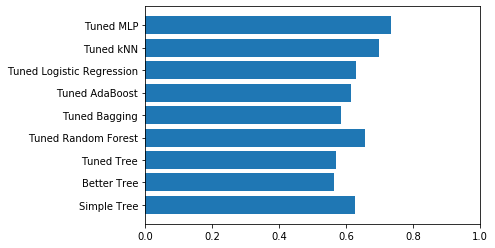

In [56]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.keys()))

In [57]:
display(model_valid_accuracy_comparisons)

{'Simple Tree': 0.6166666666666667,
 'Better Tree': 0.57,
 'Random Forest': 0.625,
 'Bagging': 0.6133333333333333,
 'AdaBoost': 0.4608333333333333,
 'Logistic Regression': 0.6208333333333333,
 'kNN': 0.6858333333333333,
 'MLP': 0.7308333333333333}

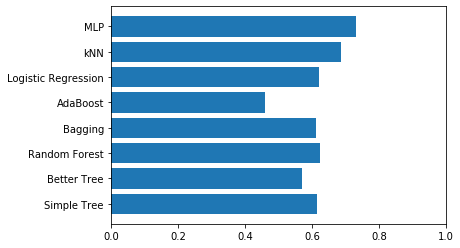

In [58]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_valid_accuracy_comparisons)), list(model_valid_accuracy_comparisons.values()), align='center')
_= plt.yticks(range(len(model_valid_accuracy_comparisons)), list(model_valid_accuracy_comparisons.keys()))

### Test Best Model On Test Dataset

In [59]:
test_dataset = pd.read_csv('fashion-mnist_test.csv')
test_dataset.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
test_X = test_dataset[test_dataset.columns[1:]]
test_Y = np.array(test_dataset["label"])

In [61]:
test_X = test_X/255

In [62]:
engineered_features_test = pd.DataFrame()

# Calcualte percentage of filled pixels and a top and bottom half only version
percent_filled = test_X.sum(axis = 1)/(28*28)
percent_filled_top = test_X.iloc[:, 0:392].sum(axis = 1)/(28*14)
percent_filled_bottom = test_X.iloc[:, 392:784].sum(axis = 1)/(28*14)
engineered_features_test['percent_filled'] = percent_filled
engineered_features_test['percent_filled_top'] = percent_filled_top
engineered_features_test['percent_filled_bottom'] = percent_filled_bottom

# Calculate the sum of each row
for idx, i in enumerate(range(0, 784, 28)):
    row_sum = test_X.iloc[:, i:(i + 28)].sum(axis = 1)/28
    engineered_features_test["row_sum_" + str(idx)] = row_sum

# Calcualte a measure of syymmetry around a horizontal axis
s1 = np.round(np.array(test_X.iloc[:, 0:392]))
s2 = np.round(np.array(test_X.iloc[:, 784:391:-1]))
s3 = np.logical_and(s1, s2).astype(int)
symmetry = s3.sum(axis = 1)/(28*28)

engineered_features_test['symmetry'] = symmetry

display(engineered_features_test.head(10))

,percent_filled,percent_filled_top,percent_filled_bottom,row_sum_0,row_sum_1,row_sum_2,row_sum_3,row_sum_4,row_sum_5,row_sum_6,...,row_sum_19,row_sum_20,row_sum_21,row_sum_22,row_sum_23,row_sum_24,row_sum_25,row_sum_26,row_sum_27,symmetry
0,0.399620,0.422389,0.376851,0.018347,0.078992,0.185994,0.414286,0.550840,0.540196,0.518347,...,0.388235,0.391737,0.395098,0.395938,0.400560,0.393697,0.370728,0.457843,0.212745,0.161990
1,0.210664,0.236134,0.185194,0.209664,0.250000,0.267647,0.291877,0.267787,0.248880,0.240756,...,0.199160,0.201821,0.199860,0.202941,0.198039,0.191317,0.185294,0.185294,0.155742,0.084184
2,0.168382,0.193377,0.143387,0.051961,0.157563,0.267507,0.189076,0.192577,0.219328,0.205462,...,0.211345,0.240196,0.157423,0.139216,0.113165,0.079272,0.072129,0.028291,0.038375,0.010204
3,0.407893,0.460554,0.355232,0.257143,0.455602,0.452101,0.430532,0.433053,0.462465,0.500560,...,0.374510,0.319888,0.264146,0.236835,0.277311,0.257423,0.475070,0.725350,0.445798,0.103316
4,0.252716,0.325090,0.180342,0.007563,0.281092,0.360924,0.362745,0.369328,0.381933,0.343277,...,0.251261,0.259664,0.216527,0.034594,0.026751,0.017647,0.016387,0.010364,0.010364,0.079082
5,0.270638,0.251210,0.290066,0.047479,0.181513,0.237255,0.223389,0.230952,0.228011,0.247899,...,0.271849,0.238515,0.256162,0.267647,0.272829,0.282353,0.298599,0.286975,0.188375,0.010204
6,0.404432,0.368958,0.439906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.395098,...,0.780532,0.792997,0.885714,0.123950,0.000000,0.000000,0.000000,0.000000,0.000000,0.202806
7,0.290756,0.255282,0.326230,0.045238,0.160784,0.236835,0.185854,0.223389,0.243417,0.255462,...,0.346359,0.344398,0.332773,0.324790,0.347059,0.280532,0.261485,0.311204,0.283193,0.052296
8,0.167462,0.139776,0.195148,0.000000,0.030952,0.163165,0.316947,0.357843,0.205042,0.085294,...,0.124790,0.178571,0.183333,0.178011,0.339916,0.399860,0.423249,0.176331,0.000000,0.033163
9,0.215581,0.257233,0.173930,0.046218,0.245238,0.248319,0.227731,0.203221,0.267227,0.389776,...,0.175350,0.173389,0.176611,0.185014,0.180952,0.190616,0.192297,0.224090,0.107423,0.000000


In [63]:
test_X = engineered_features_test

In [64]:
my_model = linear_model.LogisticRegression(C=0.4,max_iter = 1000,multi_class='ovr',solver='liblinear')
my_model = my_model.fit(X,Y)

In [65]:
# Make a set of predictions for the test data
y_pred = my_model.predict(test_X)

# Print performance details
accuracy = metrics.accuracy_score(test_Y, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(test_Y, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(test_Y), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6157
              precision    recall  f1-score   support

           0       0.65      0.60      0.63      1000
           1       0.64      0.90      0.75      1000
           2       0.50      0.54      0.52      1000
           3       0.51      0.56      0.54      1000
           4       0.51      0.51      0.51      1000
           5       0.61      0.66      0.63      1000
           6       0.42      0.16      0.23      1000
           7       0.76      0.79      0.77      1000
           8       0.74      0.69      0.72      1000
           9       0.71      0.74      0.72      1000

    accuracy                           0.62     10000
   macro avg       0.60      0.62      0.60     10000
weighted avg       0.60      0.62      0.60     10000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,604,142,32,114,28,15,24,1,37,3,1000
1,30,901,21,36,5,4,2,0,1,0,1000
2,29,94,543,56,173,19,57,0,21,8,1000
3,97,124,69,565,23,70,37,0,13,2,1000
4,11,46,212,55,507,17,65,0,81,6,1000
5,4,3,3,59,2,659,9,144,8,109,1000
6,147,96,128,153,200,64,160,0,40,12,1000
7,0,0,0,0,0,131,0,787,2,80,1000
8,9,1,22,40,47,56,7,41,692,85,1000
